## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [5]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from pprint import pprint

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [7]:
# Opening JSON file
file_path='complaints-2021-05-14_08_16.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# returns JSON object as
# a dictionary
# data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [9]:
# Inspect the dataframe to understand the given data.
print('Dataset Shape: ',df.shape)
df.head()

Dataset Shape:  (78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [10]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [11]:
# chekcing number of rows with blank complaints
df[df['_source.complaint_what_happened'].str.strip() == ''].shape

(57241, 22)

In [12]:
#Assign nan in place of blanks in the complaints column
df.loc[df['_source.complaint_what_happened'].str.strip() == '', '_source.complaint_what_happened'] = np.nan

In [13]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['_source.complaint_what_happened'])
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
# Function to complaints
def clean_complaint(complaint):
    # Convert to lowercase
    complaint = complaint.lower()
    # Remove text in square brackets
    complaint = re.sub(r'\[.*?\]', '', complaint)
    # Remove punctuation
    complaint = re.sub(r'[^\w\s]', '', complaint)
    # Remove words containing numbers
    complaint = re.sub(r'\b\w*\d\w*\b', '', complaint)
    return complaint

df['_source.complaint_what_happened'] = df['_source.complaint_what_happened'].apply(clean_complaint)
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told ...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket ...,Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it i...,Funds not handled or disbursed as instructed,Consent provided


In [16]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[['_source.complaint_what_happened']]
df_clean.columns = ['complaint_what_happened']
df_clean.head()

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...


In [17]:
# downloading wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
#Write your function to Lemmatize the texts
lemmatizer = WordNetLemmatizer()

# Function to lemmatize text
def lemmatize_text(text):
    # Tokenize the text into words
    words = text.split()
    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Join the lemmatized words back into a single string
    return ' '.join(lemmatized_words)

# Apply the function to the 'complaints' column
df_clean['lematized_complaints'] = df_clean['complaint_what_happened'].apply(lemmatize_text)

C:\Users\anshu\AppData\Local\Temp\ipykernel_53788\2971326791.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
df_clean.head()

,complaint_what_happened,lematized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...


In [20]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [21]:
#Write your function to extract the POS tags
from nltk import word_tokenize, pos_tag

def get_nouns(text):
    tokens = word_tokenize(text)  # Tokenize the text
    tagged_tokens = pos_tag(tokens)  # Get POS tags
    
    # Filter words with POS tag 'NN' (Singular Nouns)
    nouns = [word for word, pos in tagged_tokens if pos == 'NN']
    return ' '.join(nouns)

df_clean["complaint_POS_removed"] =  df_clean['lematized_complaints'].apply(get_nouns) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


C:\Users\anshu\AppData\Local\Temp\ipykernel_53788\2285388562.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,lematized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




C:\Users\anshu\AppData\Local\Temp\ipykernel_53788\1559096198.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anshu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



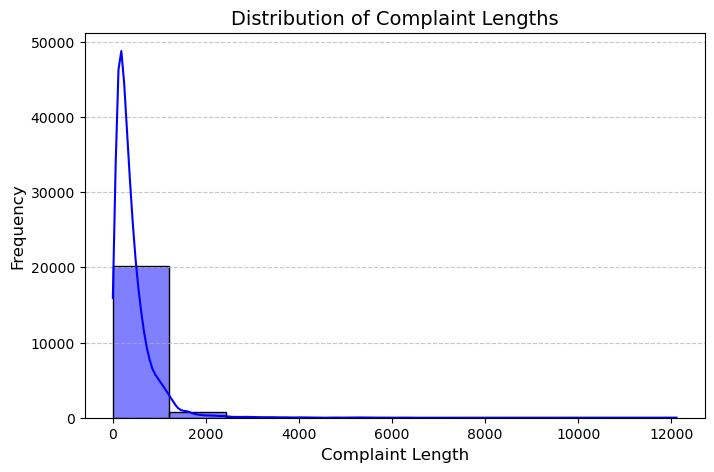

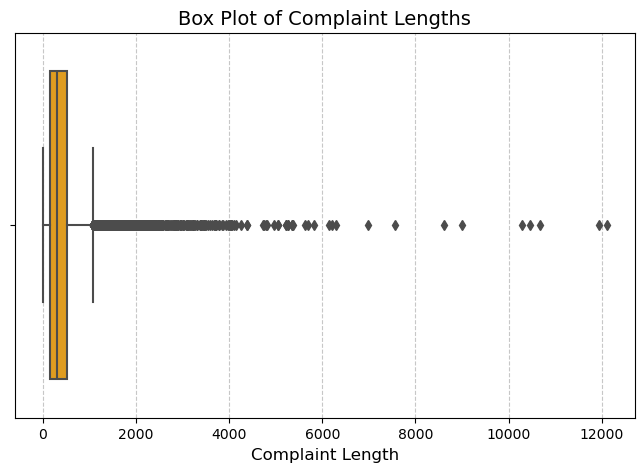

In [24]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_POS_removed_text_length'] = df_clean['complaint_POS_removed'].apply(len)

# Visualization 1: Histogram of text lengths
plt.figure(figsize=(8, 5))
sns.histplot(df_clean['complaint_POS_removed_text_length'], bins=10, kde=True, color='blue')
plt.title('Distribution of Complaint Lengths', fontsize=14)
plt.xlabel('Complaint Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization 2: Box plot of text lengths
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_clean['complaint_POS_removed_text_length'], color='orange')
plt.title('Box Plot of Complaint Lengths', fontsize=14)
plt.xlabel('Complaint Length', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [26]:
!pip install wordcloud

In [27]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
from collections import Counter

# Combine all text into a single string
text_data = ' '.join(df_clean['complaint_POS_removed'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_data)

# Calculate word frequencies
word_list = text_data.split()
word_frequencies = Counter(word_list)
top_40_words = word_frequencies.most_common(40)

# Create a DataFrame for the top 40 words
top_words_df = pd.DataFrame(top_40_words, columns=['Word', 'Frequency'])

# Display the top 40 words
print(top_words_df)

           Word  Frequency
0             i     127478
1         chase      51080
2       account      47647
3          xxxx      38371
4        credit      33094
5            wa      32998
6          card      29587
7          bank      28233
8       payment      21167
9          time      16038
10          day      12972
11     xxxxxxxx      12571
12       charge      12237
13        money      11961
14         loan      10982
15        check      10177
16       letter       9669
17  information       9654
18          fee       8687
19  transaction       8650
20       number       8604
21        month       8463
22       amount       8363
23         year       8292
24     mortgage       8179
25           ha       8164
26     customer       8163
27      balance       7754
28      company       7630
29      service       7595
30        phone       7589
31       report       7215
32        fraud       7115
33        claim       7053
34         fund       6980
35         call       6926
3

In [28]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

C:\Users\anshu\AppData\Local\Temp\ipykernel_53788\3655474111.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [30]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
text_data = ' '.join(df_clean['Complaint_clean'])

# Tokenize the text into unigrams (split by whitespace)
unigrams = text_data.split()

# Calculate word frequencies
word_frequencies = Counter(unigrams)

# Get the top 30 unigrams by frequency
top_30_unigrams = word_frequencies.most_common(30)

# Convert to DataFrame for better readability
top_unigrams_df = pd.DataFrame(top_30_unigrams, columns=['Word', 'Frequency'])

# Display the DataFrame
print(top_unigrams_df)

           Word  Frequency
0             i     127478
1         chase      51080
2       account      47647
3          xxxx      38371
4        credit      33094
5            wa      32998
6          card      29587
7          bank      28233
8       payment      21167
9          time      16038
10          day      12972
11     xxxxxxxx      12571
12       charge      12237
13        money      11961
14         loan      10982
15        check      10177
16       letter       9669
17  information       9654
18          fee       8687
19  transaction       8650
20       number       8604
21        month       8463
22       amount       8363
23         year       8292
24     mortgage       8179
25           ha       8164
26     customer       8163
27      balance       7754
28      company       7630
29      service       7595


In [31]:
#Print the top 10 words in the unigram frequency
print(top_unigrams_df.head(10))

      Word  Frequency
0        i     127478
1    chase      51080
2  account      47647
3     xxxx      38371
4   credit      33094
5       wa      32998
6     card      29587
7     bank      28233
8  payment      21167
9     time      16038


In [32]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).

from nltk import bigrams

def generate_bigrams(sentence):
    tokens = word_tokenize(sentence)  # Tokenize the sentence
    return list(bigrams(tokens))     # Generate bigrams

# Create a list of all bigrams across the DataFrame
all_bigrams = []
for sentence in df_clean['Complaint_clean']:
    all_bigrams.extend(generate_bigrams(sentence))

# Count bigram frequencies
bigram_frequencies = Counter(all_bigrams)

# Get the top 30 most frequent bigrams
top_30_bigrams = bigram_frequencies.most_common(30)

# Convert to DataFrame for better readability
top_bigrams_df = pd.DataFrame(top_30_bigrams, columns=['Bigram', 'Frequency'])

# Display the top 30 bigrams frequencies
print(top_bigrams_df)

                 Bigram  Frequency
0        (credit, card)      12803
1            (i, chase)       7600
2                (i, i)       6220
3             (xxxx, i)       5836
4          (account, i)       5518
5         (xxxxxxxx, i)       4903
6          (i, account)       4191
7      (credit, report)       3871
8          (xxxx, xxxx)       3812
9           (i, credit)       3603
10            (i, bank)       3558
11            (card, i)       3521
12            (i, xxxx)       3330
13         (i, payment)       3091
14  (customer, service)       3079
15      (chase, credit)       2981
16     (chase, account)       2819
17              (wa, i)       2807
18        (chase, bank)       2780
19           (chase, i)       2754
20        (account, wa)       2746
21      (bank, account)       2704
22     (account, chase)       2298
23            (i, card)       2252
24         (payment, i)       2148
25            (time, i)       2136
26          (i, letter)       2040
27              (i, 

In [33]:
#Print the top 10 words in the bigram frequency
print(top_bigrams_df.head(10))

             Bigram  Frequency
0    (credit, card)      12803
1        (i, chase)       7600
2            (i, i)       6220
3         (xxxx, i)       5836
4      (account, i)       5518
5     (xxxxxxxx, i)       4903
6      (i, account)       4191
7  (credit, report)       3871
8      (xxxx, xxxx)       3812
9       (i, credit)       3603


In [34]:
from nltk import trigrams

#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
def generate_trigrams(sentence):
    tokens = word_tokenize(sentence)  # Tokenize the sentence
    return list(trigrams(tokens))     # Generate trigrams

# Create a list of all trigrams across the DataFrame
all_trigrams = []
for sentence in df_clean['Complaint_clean']:
    all_trigrams.extend(generate_trigrams(sentence))

# Count trigram frequencies
trigram_frequencies = Counter(all_trigrams)

# Get the top 30 most frequent trigrams
top_30_trigrams = trigram_frequencies.most_common(30)

# Convert to DataFrame for better readability
top_trigrams_df = pd.DataFrame(top_30_trigrams, columns=['Trigram', 'Frequency'])

# Display the top 30 trigram frequencies
print(top_trigrams_df)

                        Trigram  Frequency
0         (chase, credit, card)       2061
1             (i, credit, card)       1671
2             (credit, card, i)       1205
3       (credit, card, account)       1014
4       (credit, card, company)        980
5        (i, customer, service)        736
6               (xxxx, xxxx, i)        612
7         (credit, card, chase)        596
8               (i, account, i)        522
9     (inquiry, credit, report)        510
10           (i, chase, credit)        464
11         (xxxxxxxx, i, chase)        453
12                 (i, xxxx, i)        438
13          (account, i, chase)        436
14                (i, chase, i)        430
15              (i, payment, i)        396
16           (i, letter, chase)        394
17  (credit, reporting, agency)        388
18             (xxxx, i, chase)        384
19              (i, xxxx, xxxx)        384
20          (i, chase, account)        382
21       (credit, card, credit)        379
22         

In [35]:
#Print the top 10 words in the trigram frequency
top_trigrams_df.head(10)

,Trigram,Frequency
0,"(chase, credit, card)",2061
1,"(i, credit, card)",1671
2,"(credit, card, i)",1205
3,"(credit, card, account)",1014
4,"(credit, card, company)",980
5,"(i, customer, service)",736
6,"(xxxx, xxxx, i)",612
7,"(credit, card, chase)",596
8,"(i, account, i)",522
9,"(inquiry, credit, report)",510


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [37]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

C:\Users\anshu\AppData\Local\Temp\ipykernel_53788\619742717.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,lematized_complaints,complaint_POS_removed,complaint_POS_removed_text_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,153,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,103,i card agent upgrade date agent wa information...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,70,card wa application identity consent service c...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,434,book ticket i offer ticket card i information...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,170,son deposit chase account fund chase bank acco...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [40]:
#Write your code here to initialise the TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.98,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [42]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

# Fit and transform the text data to generate the TF-IDF matrix
tfidf = vectorizer.fit_transform(df_clean['Complaint_clean'])

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Convert the sparse matrix to a dense DataFrame
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=feature_names)

# Display the TF-IDF DataFrame
print(tfidf_df)

        __  ___  ____   aa  aarp   ab  abandonment  abatement  abbreviation  \
0      0.0  0.0   0.0  0.0   0.0  0.0          0.0        0.0           0.0   
1      0.0  0.0   0.0  0.0   0.0  0.0          0.0        0.0           0.0   
2      0.0  0.0   0.0  0.0   0.0  0.0          0.0        0.0           0.0   
3      0.0  0.0   0.0  0.0   0.0  0.0          0.0        0.0           0.0   
4      0.0  0.0   0.0  0.0   0.0  0.0          0.0        0.0           0.0   
...    ...  ...   ...  ...   ...  ...          ...        ...           ...   
21067  0.0  0.0   0.0  0.0   0.0  0.0          0.0        0.0           0.0   
21068  0.0  0.0   0.0  0.0   0.0  0.0          0.0        0.0           0.0   
21069  0.0  0.0   0.0  0.0   0.0  0.0          0.0        0.0           0.0   
21070  0.0  0.0   0.0  0.0   0.0  0.0          0.0        0.0           0.0   
21071  0.0  0.0   0.0  0.0   0.0  0.0          0.0        0.0           0.0   

       abd  ...  youth  youve   yr  ytd  zero  zero

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [44]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [46]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [47]:
nmf_model.fit(tfidf)
H = nmf_model.components_ # Topic-term matrix
len(vectorizer.get_feature_names_out())

C:\Users\anshu\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



6968

In [48]:
#Print the Top15 words for each of the topics

words = np.array(vectorizer.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,chase,fund,wa,deposit,branch,day,transaction,number,business,checking,claim
Topic 2,card,charge,chase,credit,wa,dispute,transaction,purchase,fraud,service,merchant,fee,time,claim,company
Topic 3,payment,balance,fee,month,statement,wa,day,time,date,auto,credit,chase,account,year,error
Topic 4,credit,report,inquiry,card,account,score,bureau,company,debt,reporting,information,limit,application,identity,chase
Topic 5,loan,mortgage,chase,home,modification,property,year,wa,letter,rate,time,document,foreclosure,bank,house


In [49]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_values = nmf_model.transform(tfidf)
topic_values.argmax(axis=1)

array([0, 1, 3, ..., 1, 2, 2], dtype=int64)

In [50]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_values.argmax(axis=1) #write your code to assign topics to each rows.

C:\Users\anshu\AppData\Local\Temp\ipykernel_53788\2925386490.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
df_clean.head()

,complaint_what_happened,lematized_complaints,complaint_POS_removed,complaint_POS_removed_text_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,153,morning name stop bank cardmember service debt...,0
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,103,i card agent upgrade date agent wa information...,1
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,70,card wa application identity consent service c...,3
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,434,book ticket i offer ticket card i information...,3
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,170,son deposit chase account fund chase bank acco...,0


In [52]:
#Print the first 5 Complaint for each of the Topics
df_clean_temp=df_clean.groupby('Topic').head(5)
df_clean_temp.sort_values('Topic')

,complaint_what_happened,lematized_complaints,complaint_POS_removed,complaint_POS_removed_text_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,153,morning name stop bank cardmember service debt...,0
24,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and ...,mishandling account auto xxxx,29,mishandling account auto,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,jp chase account debit card tuesday thursday b...,647,jp chase account debit card tuesday thursday b...,0
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,170,son deposit chase account fund chase bank acco...,0
27,i opened an account with chase bank on xxxx an...,i opened an account with chase bank on xxxx an...,i account bank xxxx code bonus i term everythi...,125,i account bank code bonus i term everything w...,0
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx a sofa love seat table and chair and...,xxxx love seat table chair wa debit card bank ...,67,love seat table chair wa debit card bank clai...,1
21,on xxxx i made a payment to an online retail...,on xxxx i made a payment to an online retailer...,xxxx i payment retailer pay xxxx chase website...,1175,i payment retailer pay chase website i scam ...,1
45,i made a purchase with xxxx xxxx xxxx on in t...,i made a purchase with xxxx xxxx xxxx on in th...,i purchase amount i transaction i dispute case...,568,i purchase amount i transaction i dispute case...,1
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,103,i card agent upgrade date agent wa information...,1
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase wa catering order i brother funeral amou...,572,chase wa catering order i brother funeral amou...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [54]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Theft/Dispute Reporting',
    2: 'Others',
    3: 'Credit card or prepaid card',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

C:\Users\anshu\AppData\Local\Temp\ipykernel_53788\3631620719.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
df_clean.head(10)

,complaint_what_happened,lematized_complaints,complaint_POS_removed,complaint_POS_removed_text_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,153,morning name stop bank cardmember service debt...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,103,i card agent upgrade date agent wa information...,Theft/Dispute Reporting
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,70,card wa application identity consent service c...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,434,book ticket i offer ticket card i information...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,170,son deposit chase account fund chase bank acco...,Bank Account services
15,can you please remove inquiry,can you please remove inquiry,inquiry,7,inquiry,Credit card or prepaid card
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,jp chase account debit card tuesday thursday b...,647,jp chase account debit card tuesday thursday b...,Bank Account services
20,during the summer months i experience a declin...,during the summer month i experience a decline...,summer month i income employment month payment...,600,summer month i income employment month payment...,Others
21,on xxxx i made a payment to an online retail...,on xxxx i made a payment to an online retailer...,xxxx i payment retailer pay xxxx chase website...,1175,i payment retailer pay chase website i scam ...,Theft/Dispute Reporting
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,chase credit card credit report company issue,45,chase credit card credit report company issue,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [57]:
#Create the dictionary again of Topic names and Topics
Topic_names = {
    'Bank Account services': 0,
    'Theft/Dispute Reporting': 1,
    'Others': 2,
    'Credit card or prepaid card': 3,
    'Mortgage/Loan': 4
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

C:\Users\anshu\AppData\Local\Temp\ipykernel_53788\157592098.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
df_clean['Topic'].value_counts()

Topic
0    5784
1    5721
4    3854
3    3223
2    2490
Name: count, dtype: int64

In [59]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [60]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,3
11,on while trying to book a xxxx xxxx ticket ...,3
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,1
78310,i am not familiar with xxxx pay and did not un...,1
78311,i have had flawless credit for yrs ive had ch...,2


### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [62]:
#Write your code to get the Vector count
count_vect=CountVectorizer(stop_words='english')
X_train_counts=count_vect.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer=TfidfTransformer()
X_train_tf=tfidf_transformer.fit_transform(X_train_counts)

# Create the train and test data using the train_test_split on tf-idf and topics
train_X, test_X, train_y, test_y = train_test_split(X_train_tf, training_data['Topic'], test_size=0.2, random_state=40)

In [63]:
print(f'train_X - {train_X.shape}')
print(f'test_X - {test_X.shape}')
print(f'train_y - {train_y.shape}')
print(f'test_y - {test_y.shape}')

train_X - (16857, 33356)
test_X - (4215, 33356)
train_y - (16857,)
test_y - (4215,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [65]:
# Write your code here to build any 3 models and evaluate them using the required metrics

### 1. Decision Tree

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [68]:
!pip install six

#### Building Model

In [70]:
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=10)

#### Evaluating Model

In [72]:
def evaluate_dt_model(dt):
    y_train_pred = dt.predict(train_X)
    y_test_pred = dt.predict(test_X)

    print(f'Train Accuracy - {accuracy_score(train_y, y_train_pred)}')
    print(f'Test Accuracy - {accuracy_score(test_y, y_test_pred)}')

    print('-'*50)
    print(f'Train Confusion Matrix {confusion_matrix(train_y, y_train_pred)}')
    print(f'Test Confusion Matrix {confusion_matrix(test_y, y_test_pred)}')

In [73]:
evaluate_dt_model(dt)

Train Accuracy - 0.856676751497894
Test Accuracy - 0.7912218268090154
--------------------------------------------------
Train Confusion Matrix [[4003  324   29   64  204]
 [ 247 3871   22  109  332]
 [  91   61 1709   25   84]
 [ 140  230   11 2074  132]
 [ 166   73   28   44 2784]]
Test Confusion Matrix [[966  97  24  18  55]
 [ 82 889  20  63  86]
 [ 29  40 388  21  42]
 [ 37 101  10 445  43]
 [ 44  15  32  21 647]]


---

### 2. Random Forests

In [76]:
from sklearn.ensemble import RandomForestClassifier

#### Building Model

In [78]:
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20)

In [79]:
rf.fit(train_X, train_y)

RandomForestClassifier(max_depth=20, random_state=42)

In [80]:
rf.estimators_

[DecisionTreeClassifier(max_depth=20, max_features='sqrt',
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt',
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt',
                        random_state=1935803228),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt',
                        random_state=787846414),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt',
                        random_state=996406378),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt',
                        random_state=1201263687),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt',
                        random_state=423734972),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt',
                        random_state=415968276),
 DecisionTreeClassifier(max_depth=20, max_features='sqrt',
                        random_state=670094950),
 DecisionTreeClassifier(

#### Evaluating Model

In [82]:
evaluate_dt_model(rf)

Train Accuracy - 0.8840837634217239
Test Accuracy - 0.7655990510083037
--------------------------------------------------
Train Confusion Matrix [[4528   86    0    9    1]
 [ 173 4397    0    8    3]
 [ 349  275 1204   34  108]
 [ 173  323    3 2076   12]
 [ 284   95    1   17 2698]]
Test Confusion Matrix [[1061   86    1   11    1]
 [ 109 1020    1    7    3]
 [ 126  147  147   25   75]
 [  39  171    1  402   23]
 [ 115   38    2    7  597]]


---

### 3. Logistic Regression

In [90]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# importing libraries required for model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split

from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [92]:
# Function to evaluate the model and display the results
def eval_model(y_test, y_pred, y_pred_proba, type='Training'):
    print(type, 'results')
    print('Accuracy:', round(accuracy_score(y_test, y_pred), 2))
    print('Precision:', round(precision_score(y_test, y_pred, average='weighted'), 2))
    print('Recall:', round(recall_score(y_test, y_pred, average='weighted'), 2))
    print('F1 Score:', round(f1_score(y_test, y_pred, average='weighted'), 2))

    # Handle ROC AUC for multiple classes safely
    try:
        print('ROC AUC Score:', round(roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr'), 2))
    except ValueError:
        print('ROC AUC Score: Not applicable for this case')

    print('Classification Report:\n', classification_report(y_test, y_pred))

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(y_test) | set(y_pred)))
    disp.plot()

In [93]:
# function to grid search the best parameters for the model
def run_model(model,param_grid):
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=40)
    grid=GridSearchCV(model,param_grid={},cv=cv,scoring='f1_weighted',verbose=1,n_jobs=-1)
    grid.fit(train_X,train_y)
    return grid.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\anshu\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training results
Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 Score: 0.98
ROC AUC Score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      4624
           1       0.97      0.99      0.98      4581
           2       0.99      0.96      0.98      1970
           3       0.98      0.97      0.97      2587
           4       0.99      0.98      0.98      3095

    accuracy                           0.98     16857
   macro avg       0.98      0.98      0.98     16857
weighted avg       0.98      0.98      0.98     16857

Test results
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
ROC AUC Score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      1160
           1       0.92      0.96      0.94      1140
           2       0.98      0.87      0.92       520
           3       0.93      0.92      0.92       636
      

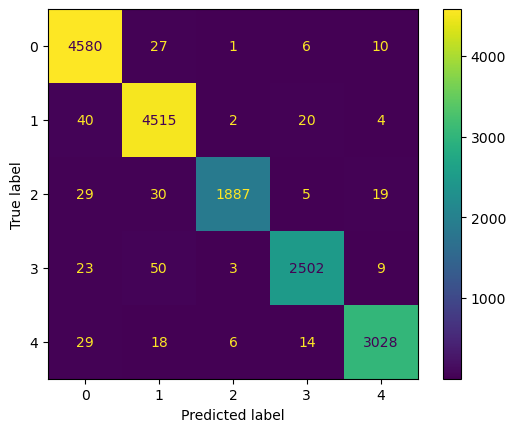

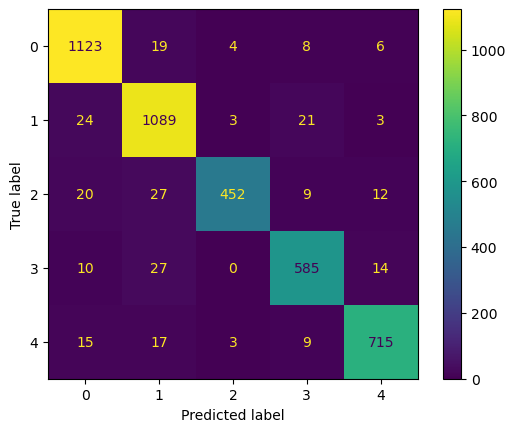

In [94]:
#running and evaluating the Logistic Regression model
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 500, 1000],
    'class_weight': [None, 'balanced']
}
model=run_model(LogisticRegression(),params)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')

### Model Evaluation Summary

1. **Decision Tree** - Train Accuracy - 86% Test Accuracy - 79%
2. **Random Forest** - Train Accuracy - 88% Test Accuracy - 77%
3. **Logistic Regression** - Train Accuracy - 98% Test Accuracy - 94%

Considering the stats shown above **Decision Tree gives us a balanced result and can be considered the best model out the 3**.

---

### Model Inference - Predicting Topic for a New Complaint

In [98]:
# Original Topic names - index map used in Topic Modelling
Topic_names_map = {
    0: 'Bank Account services',
    1: 'Theft/Dispute Reporting',
    2: 'Others',
    3: 'Credit card or prepaid card',
    4: 'Mortgage/Loan'
}

In [99]:
new_complaint = 'I am writing to dispute several fraudulent transactions on my checking account ending in 1234. These charges, totaling $2,500, were made on March 20, 2025, at merchants I have never visited. I did not authorize these transactions, and my debit card has been in my possession the entire time.I believe this is a case of fraud, as I have no connection to these charges. I have already contacted the merchants, but they informed me that the charges cannot be reversed on their end. I am filing a claim and request an immediate investigation into these unauthorized transactions. Please let me know what additional documentation you need from me to resolve this issue as soon as possible.'

df_new_complaint = pd.DataFrame([new_complaint], columns=["complaint"])

new_comp_vec=count_vect.transform(df_new_complaint['complaint'])

new_tfidf=tfidf_transformer.transform(new_comp_vec)

#### Checking Topic of the new complaint

In [101]:
print(f'Complaint Topic - {Topic_names_map[dt.predict(new_tfidf)[0]]}')

Complaint Topic - Theft/Dispute Reporting
